In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARMA
#from statsmodels.tsa.arima_model import ARIMA 

In [3]:
df = pd.read_csv('Caliber_Daily.csv')

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date'])

dff = df.loc[df['Site'] == 'CCC0611']
dff.shape

(386, 4)

In [4]:
x = dff['Date']
y = dff['Energy Consumption (kWh)']
data = pd.DataFrame({'Date': x, 'Energy Consumption (kWh)':y})

#plt.figure(figsize = (12, 8))
#data['Energy Consumption (kWh)'].plot(title = "Caliber - Energy Consumption (kWh)", label = 'CCC0611')
#plt.grid()
#plt.legend()

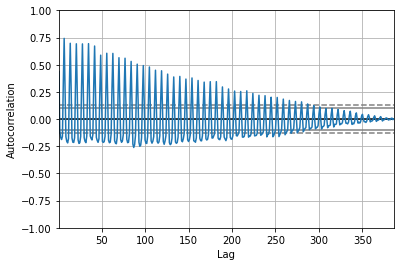

Autocorrelation is 0.4394


In [4]:
pd.plotting.autocorrelation_plot(y)
#Default is lag = 1
shift1 = y.autocorr()
plt.show()
print('Autocorrelation is', shift1.round(4))

In [ ]:
#Specify lags

plot_acf(y)
plot_pacf(y)
plt.show()

In [ ]:
round(y.mean(), 2)

In [5]:
dff['Date'].min(), dff['Date'].max()

(Timestamp('2019-11-01 00:00:00'), Timestamp('2020-11-20 00:00:00'))

In [6]:
train = dff['Energy Consumption (kWh)'].loc['2019-11-01':'2020-11-05']
test = dff['Energy Consumption (kWh)'].loc['2020-11-06':'2020-11-19']

In [7]:
len(train), len(test), round(train.mean(), 2)

(371, 14, 585.84)

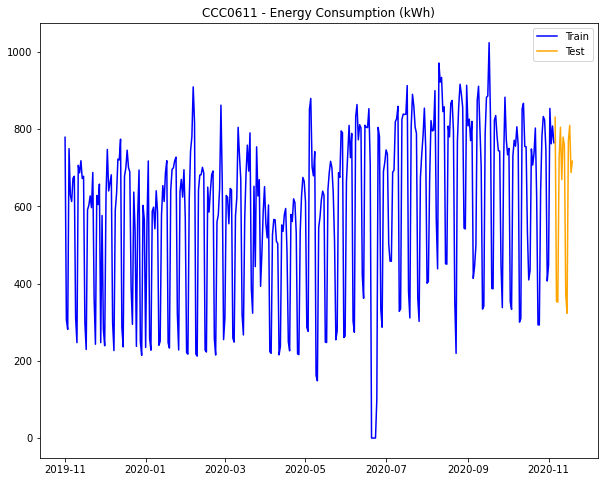

In [8]:
plt.figure(figsize = (10, 8))
plt.plot(train, color = 'b')
plt.plot(test, color = 'orange')
plt.title('CCC0611 - Energy Consumption (kWh)')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
train.hist()
plt.title('Count vs. kWh')

In [9]:
#Summary statistics

s = train.values
split = int(len(s)/2)
s1, s2 = s[0:split], s[split:]
mean1, mean2 = s1.mean(), s2.mean()
var1, var2 = s1.var(), s2.var()

print('Avg1 = %f, Avg2 = %f' % (mean1, mean2))
print('Var1 = %f, Var2 = %f' % (var1, var2))

Avg1 = 527.711784, Avg2 = 643.659032
Var1 = 35696.127731, Var2 = 53570.505256


In [ ]:
result = seasonal_decompose(train, model = 'additive')
fig = result.plot()
fig.set_size_inches(12, 8)

In [12]:
#Statistical Test

def adfuller_test(serie, figsize = (12,4), plot = True, title = ""):
#    if plot:
#        serie.plot(figsize = figsize, title = title)
#        plt.show()
    #Dickey Fuller test on the first difference
    adf = adfuller(serie)
    output = pd.Series(adf[0:4], index = ['ADF Statistic', 'p-value', 'Used Lags', 'Number of comments used'])
#    output = round(output, 4)
    
    for key, value in adf[4].items():
        output["Critical Value (%s)" %key] = value
    return output

adfuller_test(train.diff().dropna(), title = '')
#adfuller_test(train, title = '')

ADF Statistic             -7.544421e+00
p-value                    3.312418e-11
Used Lags                  1.300000e+01
Number of comments used    3.560000e+02
Critical Value (1%)       -3.448853e+00
Critical Value (5%)       -2.869693e+00
Critical Value (10%)      -2.571114e+00
dtype: float64

In [11]:
#Statistical Test: 
#Assumes the series is stationary; non-stationary if p-value is less than 5% or test statistic is above any critical value

#kpss_input = kpss(train)
kpss_input = kpss(train.diff().dropna())
kpss_test = pd.Series(kpss_input[0:3], index = ['KPSS Statistic', 'p-value', 'Used Lags'])
kpss_test = round(kpss_test, 4)
    
for key, value in kpss_input[3].items():
    kpss_test["Critical Value (%s)" %key] = value 

print(kpss_test)

KPSS Statistic            0.034
p-value                   0.100
Used Lags                17.000
Critical Value (10%)      0.347
Critical Value (5%)       0.463
Critical Value (2.5%)     0.574
Critical Value (1%)       0.739
dtype: float64


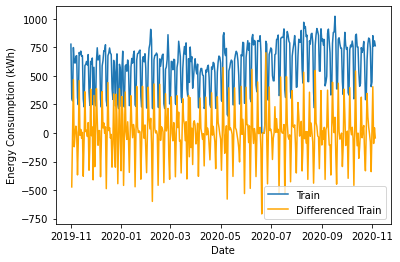

In [10]:
train_1 = train.diff().dropna()

#pd.plotting.autocorrelation_plot(train_1)
#shift1 = train_1.autocorr()
#plt.show()
#print('Autocorrelation is', shift1.round(4))

plt.plot(train)
plt.plot(train_1, color = 'orange')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend(['Train', 'Differenced Train'])

In [13]:
s = train_1.values
split = int(len(s)/2)
s1, s2 = s[0:split], s[split:]
mean1, mean2 = s1.mean(), s2.mean()
var1, var2 = s1.var(), s2.var()

print(round(s.mean(), 2))
print('Avg1 = %f, Avg2 = %f' % (mean1, mean2))
print('Var1 = %f, Var2 = %f' % (var1, var2))

-0.04
Avg1 = 0.391784, Avg2 = -0.467622
Var1 = 50690.971790, Var2 = 54949.763254


In [30]:
#ARMA(p,q): p>=2 

test_1 = test.diff().dropna()
train1 = train_1 + np.mean(train)
test1 = test_1 + np.mean(test)
#model = ARMA(train_1, order = [9, 0]).fit()
#pred = model.predict(start = len(train_1), end = len(train_1) + len(test_1))

model = ARMA(train1, order = [9, 0]).fit()
pred = model.predict(start = len(train1), end = len(train1) + len(test1))

In [34]:
#print(len(pred))
print(model.summary().tables[0])

                                 ARMA Model Results                                 
Dep. Variable:     Energy Consumption (kWh)   No. Observations:                  370
Model:                           ARMA(9, 0)   Log Likelihood               -2299.412
Method:                             css-mle   S.D. of innovations            119.968
Date:                      Thu, 03 Dec 2020   AIC                           4620.824
Time:                              15:28:09   BIC                           4663.872
Sample:                          11-02-2019   HQIC                          4637.923
                               - 11-05-2020                                         


<AxesSubplot:title={'center':'CCC0611'}, xlabel='Date'>

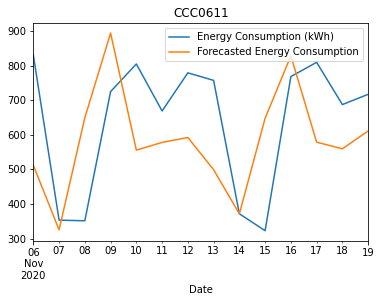

In [32]:
forecast_data = pd.DataFrame(pred, index = test.index, columns = ['Forecasted Energy Consumption'])
pd.concat([test, forecast_data], axis = 1).plot(title = "CCC0611")

In [ ]:
#preds, stderr, ci = model.forecast(len(test))

In [43]:
#compare = pd.concat([test, forecast_data], axis = 1)
#compare.head(14)

In [ ]:
#data = train.append([test])
#pd.concat([data, forecast_data], axis = 1).plot()

In [33]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

def check_error(orig, fore):
    
    resid = round(np.mean(orig - fore), 2)
    mse = mean_squared_error(orig, fore)
    rmse = round(sqrt(mse), 2)
        
    error_group = [resid, rmse]
#    serie = pd.DataFrame(error_group, columns = ['RESID','RMSE'])
#    serie.index.name = index_name
    
    return error_group

check_error(test, pred)
#resid, rmse

[53.13, 203.73]